In [3]:
predict electricity demand (nat_demand) based on weather, time, and holiday features.



# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electricity-load-forecasting/train_dataframes.xlsx
/kaggle/input/electricity-load-forecasting/continuous dataset.csv
/kaggle/input/electricity-load-forecasting/test_dataframes.xlsx
/kaggle/input/electricity-load-forecasting/weekly pre-dispatch forecast.csv


In [6]:
df = pd.read_csv('/kaggle/input/electricity-load-forecasting/continuous dataset.csv')
df.head()  

# Show the first 5 rows
print(df.head())

# Check data info to confirm datatypes and missing values
print(df.info())

# Quick stats summary
print(df.describe())

# Check for missing values
print(df.isnull().sum())

              datetime  nat_demand    T2M_toc  QV2M_toc   TQL_toc    W2M_toc  \
0  2015-01-03 01:00:00    970.3450  25.865259  0.018576  0.016174  21.850546   
1  2015-01-03 02:00:00    912.1755  25.899255  0.018653  0.016418  22.166944   
2  2015-01-03 03:00:00    900.2688  25.937280  0.018768  0.015480  22.454911   
3  2015-01-03 04:00:00    889.9538  25.957544  0.018890  0.016273  22.110481   
4  2015-01-03 05:00:00    893.6865  25.973840  0.018981  0.017281  21.186089   

     T2M_san  QV2M_san   TQL_san    W2M_san    T2M_dav  QV2M_dav   TQL_dav  \
0  23.482446  0.017272  0.001855  10.328949  22.662134  0.016562  0.096100   
1  23.399255  0.017265  0.001327  10.681517  22.578943  0.016509  0.087646   
2  23.343530  0.017211  0.001428  10.874924  22.531030  0.016479  0.078735   
3  23.238794  0.017128  0.002599  10.518620  22.512231  0.016487  0.068390   
4  23.075403  0.017059  0.001729   9.733589  22.481653  0.016456  0.064362   

    W2M_dav  Holiday_ID  holiday  school  
0  5.36

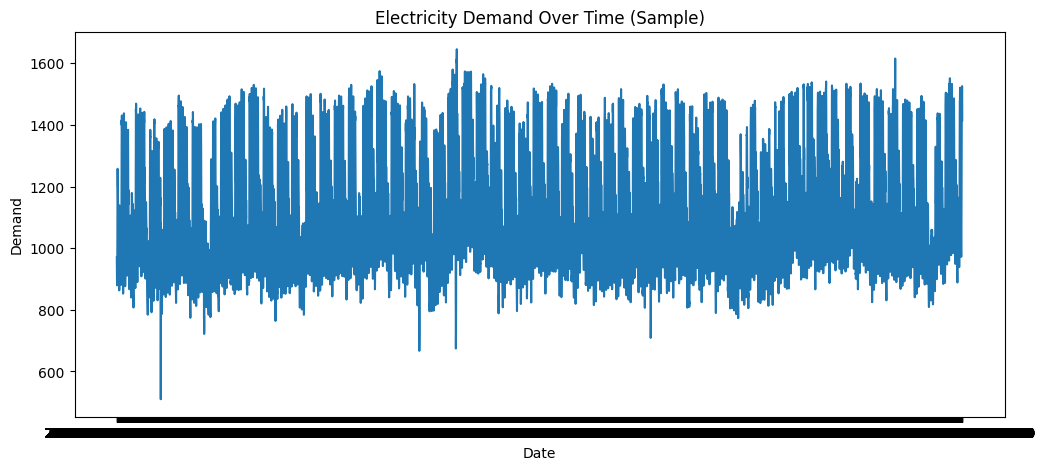

In [10]:
plt.figure(figsize=(12,5))
plt.plot(df['datetime'][:10000], df['nat_demand'][:10000])
plt.title('Electricity Demand Over Time (Sample)')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.show()


In [14]:
# Convertir la columna 'datetime' a datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Crear características lag para demanda pasada
for lag in [1, 2, 3, 24, 48]:
    df[f'nat_demand_lag_{lag}'] = df['nat_demand'].shift(lag)

# Eliminar filas con NaN generados por los lags
df = df.dropna()

# Extraer características basadas en tiempo
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month

# Convertir variables categóricas
df['holiday'] = df['holiday'].astype('category')
df['school'] = df['school'].astype('category')


In [16]:
# Define cutoff date for train/test split (e.g., train until end of 2016)
cutoff_date = '2017-01-01'

train = df[df['datetime'] < cutoff_date]
test = df[df['datetime'] >= cutoff_date]

# Define features and target
feature_cols = [col for col in df.columns if col not in ['datetime', 'nat_demand']]
X_train = train[feature_cols]
y_train = train['nat_demand']

X_test = test[feature_cols]
y_test = test['nat_demand']

In [17]:
from sklearn.ensemble import RandomForestRegressor

# Initialize model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train model
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [18]:
y_pred = model.predict(X_test)


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')


MAE: 19.88
RMSE: 31.47
MAPE: 1.70%


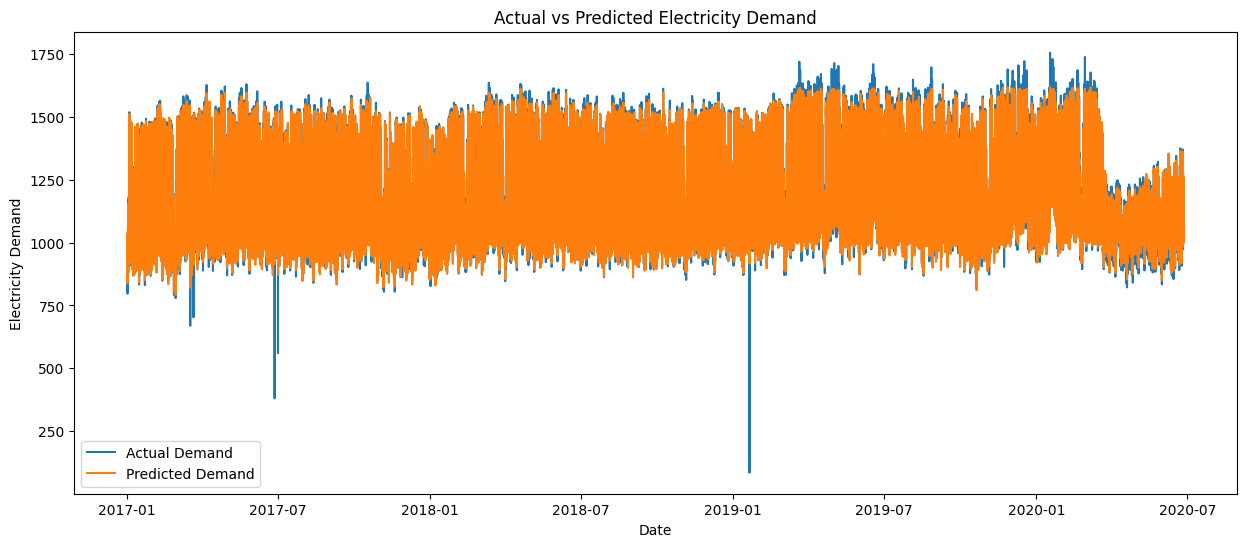

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test['datetime'], y_test, label='Actual Demand')
plt.plot(test['datetime'], y_pred, label='Predicted Demand')
plt.xlabel('Date')
plt.ylabel('Electricity Demand')
plt.title('Actual vs Predicted Electricity Demand')
plt.legend()
plt.show()


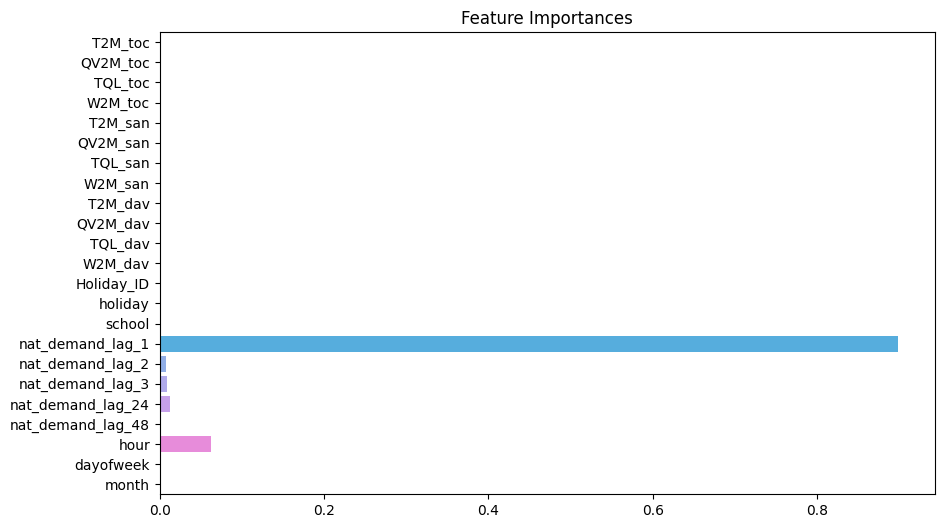

In [21]:
importances = model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title('Feature Importances')
plt.show()
